# Pronostico fallecidos acumulados y diarios en Bogotá de COVID-19

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
from keras.models import load_model

In [3]:
bogota = pd.read_csv('bogota.csv')
bogota.set_index('FECHA_DIAGNOSTICO', inplace = True)
bogota_fall = bogota.drop(['CASO', 'CASOS_ACUMULADOS', 'RECUPERADOS_ACUMULADOS','RECUPERADO','FALLECIDOS_ACUMULADOS'],axis=1)
bogota_fall

,FALLECIDOS
FECHA_DIAGNOSTICO,
2020-03-06,0
2020-03-07,0
2020-03-08,0
2020-03-09,0
2020-03-10,0
...,...
2022-03-02,3
2022-03-03,4
2022-03-04,0


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(bogota_fall)
bog_scaled_fall = scaler.transform(bogota_fall)

In [5]:
n_train_data = 670
n_test_data = 60

train_scaled_bog_fall = bog_scaled_fall[:n_train_data]
train_scaled_bog_fall

test_scaled_bog_fall = bog_scaled_fall[n_train_data:n_train_data+n_test_data]
test_scaled_bog_fall

array([[0.04854369],
       [0.09223301],
       [0.09223301],
       [0.07281553],
       [0.07281553],
       [0.08252427],
       [0.12621359],
       [0.12135922],
       [0.12135922],
       [0.11650485],
       [0.16019417],
       [0.15533981],
       [0.11165049],
       [0.17961165],
       [0.18932039],
       [0.22330097],
       [0.18446602],
       [0.32524272],
       [0.16019417],
       [0.25728155],
       [0.26213592],
       [0.25728155],
       [0.27184466],
       [0.23786408],
       [0.22330097],
       [0.17961165],
       [0.2184466 ],
       [0.16990291],
       [0.12135922],
       [0.2184466 ],
       [0.15048544],
       [0.11650485],
       [0.07281553],
       [0.19417476],
       [0.15533981],
       [0.10194175],
       [0.12135922],
       [0.06796117],
       [0.11165049],
       [0.0631068 ],
       [0.09708738],
       [0.05339806],
       [0.0776699 ],
       [0.03883495],
       [0.03883495],
       [0.02912621],
       [0.01941748],
       [0.048

In [6]:
from keras.preprocessing.sequence import TimeseriesGenerator

window_size= 60
n_features= 1
batch_size = 1

train_generator_bog = TimeseriesGenerator(train_scaled_bog_fall, train_scaled_bog_fall, length= window_size, batch_size=batch_size)
print("Total number of samples in the original training data of Bogotá = ", len(train_scaled_bog_fall))
print("Total number of samples in the generated data of Bogotá = ", len(train_generator_bog))

test_generator_bog = TimeseriesGenerator(test_scaled_bog_fall, test_scaled_bog_fall, length=len(test_scaled_bog_fall)-1 ,batch_size=batch_size)
print("Total number of samples in the original training data of Bogotá = ", len(test_scaled_bog_fall))
print("Total number of sambles in the generated data of Bogotá", len(test_generator_bog))

Total number of samples in the original training data of Bogotá =  670
Total number of samples in the generated data of Bogotá =  610
Total number of samples in the original training data of Bogotá =  60
Total number of sambles in the generated data of Bogotá 1


## Red neuronal simple

In [23]:
def model_rnn_builder(hp):
  model_rnn_bog = keras.Sequential()
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model_rnn_bog.add(LSTM(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='tanh', input_shape=(window_size, n_features),return_sequences=True))
  model_rnn_bog.add(LSTM(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='tanh'))
  model_rnn_bog.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_rnn_bog.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_rnn_bog

In [24]:
tuner = kt.BayesianOptimization(model_rnn_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_rnn',
                     project_name='hp_rnn_bog')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_bog, validation_data=test_generator_bog,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Oracle from existing project my_dir_rnn\hp_rnn_bog\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir_rnn\hp_rnn_bog\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [32]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 400 y el learning rate mas optimo será de 0.001.



In [26]:
model_rnn_bog = tuner.hypermodel.build(best_hps)
history_rnn_bog = model_rnn_bog.fit(train_generator_bog, epochs=100, validation_data=test_generator_bog, callbacks=my_callbacks)

Epoch 1/100
610/610 [==============================] - 36s 51ms/step - loss: 0.0120 - root_mean_squared_error: 0.0894 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0000e+00 - lr: 0.0010
Epoch 2/100
610/610 [==============================] - 39s 63ms/step - loss: 0.0076 - root_mean_squared_error: 0.0768 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0000e+00 - lr: 0.0010
Epoch 3/100
610/610 [==============================] - 39s 65ms/step - loss: 0.0069 - root_mean_squared_error: 0.0754 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0000e+00 - lr: 0.0010
Epoch 4/100
610/610 [==============================] - 43s 70ms/step - loss: 0.0069 - root_mean_squared_error: 0.0773 - val_loss: 7.6465e-04 - val_root_mean_squared_error: 0.0000e+00 - lr: 0.0010
Epoch 5/100
610/610 [==============================] - 41s 66ms/step - loss: 0.0063 - root_mean_squared_error: 0.0747 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0283 - lr: 0.0010
Epoch 6/100
610/610 [===================

In [ ]:
model_rnn_bog.save("model_rnn.h5")
model_rnn_bog = load_model('model_rnn.h5')

Best epoch: 5


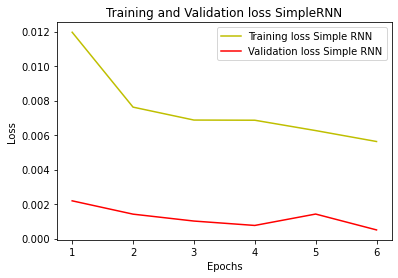

In [27]:
val_acc_per_epoch = history_rnn_bog.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_rnn_bog = history_rnn_bog.history['loss']
val_loss_rnn_bog = history_rnn_bog.history['val_loss']
epochs = range(1,len(loss_rnn_bog)+1)

plt.plot(epochs, loss_rnn_bog, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_rnn_bog, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_rnn_bog = load_model('model_rnn.h5')

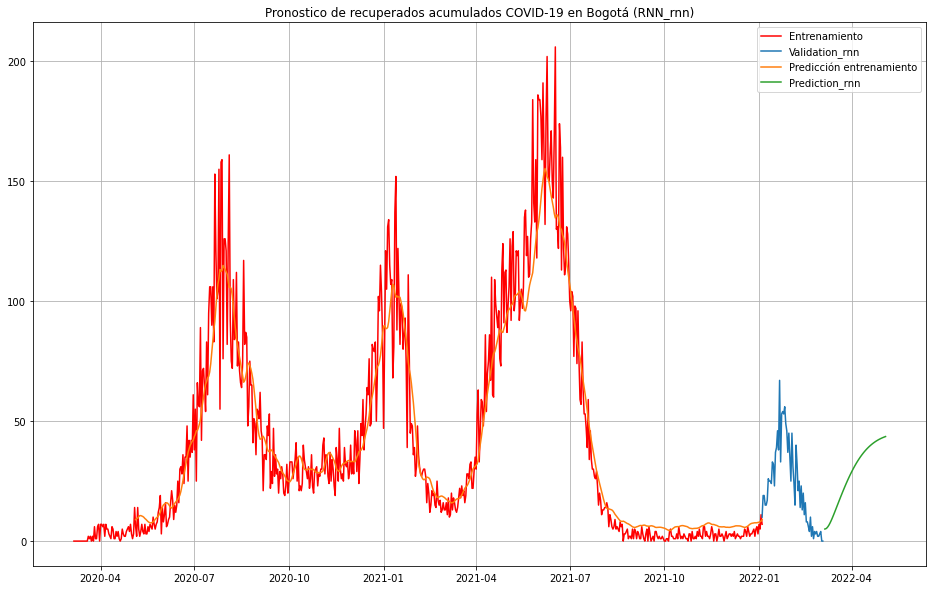

In [16]:
predictions_rnn_bog = []

first_batch = bog_scaled_fall[-window_size:]
current_batch_rnn_bog = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_rnn_bog = model_rnn_bog.predict(current_batch_rnn_bog)[0]
    

    predictions_rnn_bog.append(current_pred_rnn_bog)
    
    
    current_batch_rmv_first_rnn_bog= current_batch_rnn_bog[:,1:,:]
 

    current_batch_rnn_bog= np.append(current_batch_rmv_first_rnn_bog,[[current_pred_rnn_bog]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_bog_fall)
dates_train_data_rnn_bog = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_rnn_bog = pd.DataFrame({'Date':dates_train_data_rnn_bog,'train':train_data_actual_scale[:,0]})
df_train_rnn_bog.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_rnn_bog = model_rnn_bog.predict(train_generator_bog)
train_prediction_data_actual_scale_rnn_bog =scaler.inverse_transform(train_prediction_rnn_bog)
dates_predict_train_data_rnn_bog = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_rnn_bog = pd.DataFrame({'Date':dates_predict_train_data_rnn_bog,'train':train_prediction_data_actual_scale_rnn_bog[:,0]})
df_predict_train_rnn_bog.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_rnn_bog = scaler.inverse_transform(test_scaled_bog_fall)
dates_test_data_rnn_bog = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_rnn_bog = pd.DataFrame({'Date':dates_test_data_rnn_bog,'Test_rnn_bog':test_data_actual_scale_rnn_bog[:,0]})
df_test_rnn_bog.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_rnn_bog = scaler.inverse_transform(predictions_rnn_bog)
dates_predictions_rnn_bog  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_rnn_bog  = pd.DataFrame({'Date':dates_predictions_rnn_bog,'Predictions_rnn_bog':predictions_actual_scale_rnn_bog[:,0]})
df_predictions_rnn_bog .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_rnn_bog,'r', label='Entrenamiento')
plt.plot(df_test_rnn_bog['Test_rnn_bog'], label='Validation_rnn')
plt.plot(df_predict_train_rnn_bog['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en Bogotá (RNN_rnn)')
plt.plot(df_predictions_rnn_bog ['Predictions_rnn_bog'], label='Prediction_rnn')
plt.grid()
plt.legend()

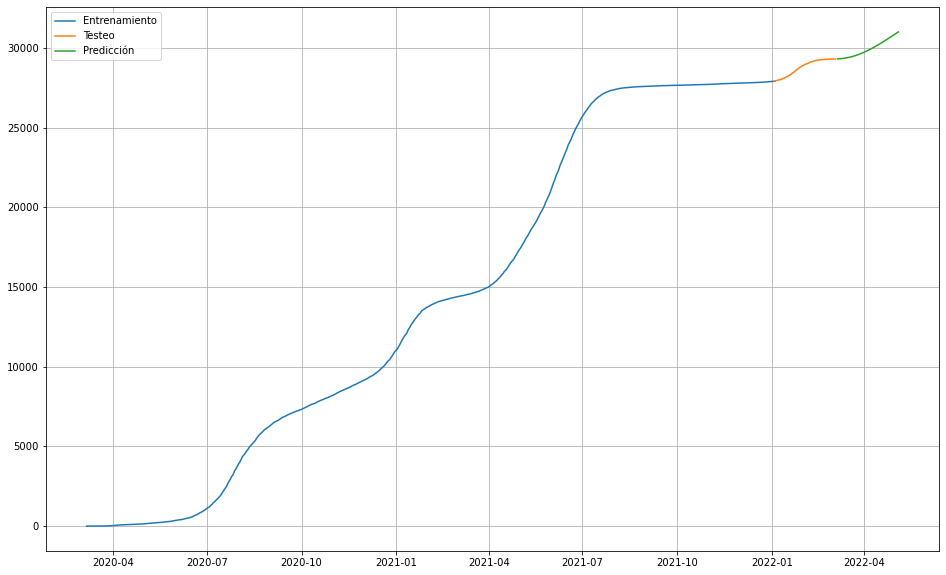

In [22]:
# Creación columna con casos acumulados.
df_predictions_rnn_bog['acumulados']= df_predictions_rnn_bog['Predictions_rnn_bog'].cumsum()
df_predictions_rnn_bog['acumulados'] = [i+bogota['FALLECIDOS_ACUMULADOS'].max() for i in df_predictions_rnn_bog.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_rnn_bog['acumulados']=df_train_rnn_bog['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_rnn_bog['acumulados']=df_test_rnn_bog['Test_rnn_bog'].cumsum()
df_test_rnn_bog['acumulados'] = [i+df_train_rnn_bog['acumulados'].max() for i in df_test_rnn_bog.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_rnn_bog['acumulados'], label='Entrenamiento' )
plt.plot(df_test_rnn_bog['acumulados'], label= 'Testeo')
plt.plot(df_predictions_rnn_bog['acumulados'], label='Predicción')
plt.grid()
plt.legend()

In [35]:
df_predictions_rnn_bog

,Predictions_rnn_bog,acumulados
Date,,
2022-03-06,5.029387,29317.029387
2022-03-07,5.159647,29322.189034
2022-03-08,5.495640,29327.684674
2022-03-09,6.015207,29333.699880
2022-03-10,6.691209,29340.391089
2022-03-11,7.494575,29347.885664
2022-03-12,8.397324,29356.282988
2022-03-13,9.373756,29365.656745
2022-03-14,10.402450,29376.059195


## Red neuronal con celdas LSTM

In [36]:
def model_lstm_builder(hp):
  model_lstm_bog = keras.Sequential()
  hp_units = hp.Int('units', min_value=50, max_value=400, step=50)
  model_lstm_bog.add(LSTM(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='tanh', input_shape=(window_size, n_features),return_sequences=True))
  model_lstm_bog.add(LSTM(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='tanh'))
  model_lstm_bog.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_lstm_bog.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_lstm_bog

In [37]:
tuner = kt.BayesianOptimization(model_lstm_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_lstm',
                     project_name='hp_lstm_bog')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_bog, validation_data=test_generator_bog,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Oracle from existing project my_dir_lstm\hp_lstm_bog\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir_lstm\hp_lstm_bog\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [38]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 400 y el learning rate mas optimo será de 0.001.



In [ ]:
model_lstm_bog = tuner.hypermodel.build(best_hps)
history_lstm_bog = model_lstm_bog.fit(train_generator_bog, epochs=100, validation_data=test_generator_bog, callbacks=my_callbacks)

In [ ]:
model_lstm_bog.save("model_lstm.h5")

In [18]:
model_lstm_bog = load_model('model_lstm.h5')

In [ ]:
val_acc_per_epoch = history_lstm_bog.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_lstm_bog = history_lstm_bog.history['loss']
val_loss_lstm_bog = history_lstm_bog.history['val_loss']
epochs = range(1,len(loss_lstm_bog)+1)

plt.plot(epochs, loss_lstm_bog, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_lstm_bog, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

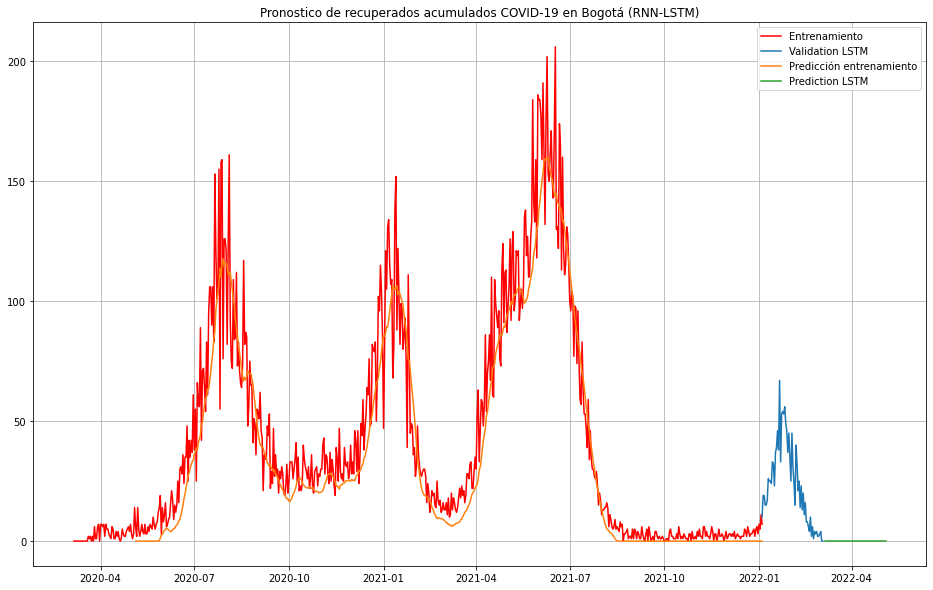

In [20]:
predictions_lstm_bog = []

first_batch = bog_scaled_fall[-window_size:]
current_batch_lstm_bog = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_lstm_bog = model_lstm_bog.predict(current_batch_lstm_bog)[0]
    

    predictions_lstm_bog.append(current_pred_lstm_bog)
    
    
    current_batch_rmv_first_lstm_bog= current_batch_lstm_bog[:,1:,:]
 

    current_batch_lstm_bog= np.append(current_batch_rmv_first_lstm_bog,[[current_pred_lstm_bog]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_bog_fall)
dates_train_data_lstm_bog = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_lstm_bog = pd.DataFrame({'Date':dates_train_data_lstm_bog,'train':train_data_actual_scale[:,0]})
df_train_lstm_bog.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_lstm_bog = model_lstm_bog.predict(train_generator_bog)
train_prediction_data_actual_scale_lstm_bog =scaler.inverse_transform(train_prediction_lstm_bog)
dates_predict_train_data_lstm_bog = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_lstm_bog = pd.DataFrame({'Date':dates_predict_train_data_lstm_bog,'train':train_prediction_data_actual_scale_lstm_bog[:,0]})
df_predict_train_lstm_bog.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_lstm_bog = scaler.inverse_transform(test_scaled_bog_fall)
dates_test_data_lstm_bog = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_lstm_bog = pd.DataFrame({'Date':dates_test_data_lstm_bog,'Test_LSTM_bog':test_data_actual_scale_lstm_bog[:,0]})
df_test_lstm_bog.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_lstm_bog = scaler.inverse_transform(predictions_lstm_bog)
dates_predictions_lstm_bog  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_lstm_bog  = pd.DataFrame({'Date':dates_predictions_lstm_bog,'Predictions_LSTM_bog':predictions_actual_scale_lstm_bog[:,0]})
df_predictions_lstm_bog .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_lstm_bog,'r', label='Entrenamiento')
plt.plot(df_test_lstm_bog['Test_LSTM_bog'], label='Validation LSTM')
plt.plot(df_predict_train_lstm_bog['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en Bogotá (RNN-LSTM)')
plt.plot(df_predictions_lstm_bog ['Predictions_LSTM_bog'], label='Prediction LSTM')
plt.grid()
plt.legend()

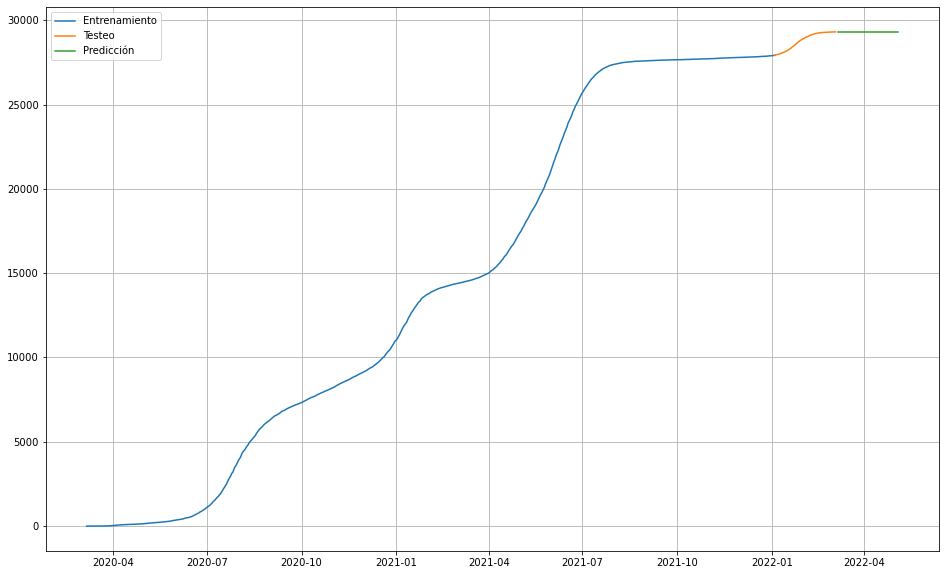

In [21]:
# Creación columna con casos acumulados.
df_predictions_lstm_bog['acumulados']= df_predictions_lstm_bog['Predictions_LSTM_bog'].cumsum()
df_predictions_lstm_bog['acumulados'] = [i+bogota['FALLECIDOS_ACUMULADOS'].max() for i in df_predictions_lstm_bog.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_lstm_bog['acumulados']=df_train_lstm_bog['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_lstm_bog['acumulados']=df_test_lstm_bog['Test_LSTM_bog'].cumsum()
df_test_lstm_bog['acumulados'] = [i+df_train_lstm_bog['acumulados'].max() for i in df_test_lstm_bog.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_lstm_bog['acumulados'], label='Entrenamiento' )
plt.plot(df_test_lstm_bog['acumulados'], label= 'Testeo')
plt.plot(df_predictions_lstm_bog['acumulados'], label='Predicción')
plt.grid()
plt.legend()

## Red neuronal con celdas GRU

In [7]:
def model_gru_builder(hp):
  model_gru_bog = keras.Sequential()
  hp_units = hp.Int('units', min_value=50, max_value=400, step=50)
  model_gru_bog.add(GRU(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='tanh', input_shape=(window_size, n_features),return_sequences=True))
  model_gru_bog.add(GRU(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='tanh'))
  model_gru_bog.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_gru_bog.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_gru_bog

In [8]:
tuner = kt.BayesianOptimization(model_gru_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_gru',
                     project_name='hp_gru_bog')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_bog, validation_data=test_generator_bog,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Oracle from existing project my_dir_gru\hp_gru_bog\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir_gru\hp_gru_bog\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [34]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 400 y el learning rate mas optimo será de 0.001.



In [ ]:
model_gru_bog = tuner.hypermodel.build(best_hps)
history_gru_bog = model_gru_bog.fit(train_generator_bog, epochs=3, validation_data=test_generator_bog, callbacks=my_callbacks)

In [12]:
model_gru_bog.save("model_gru.h5")


Best epoch: 1


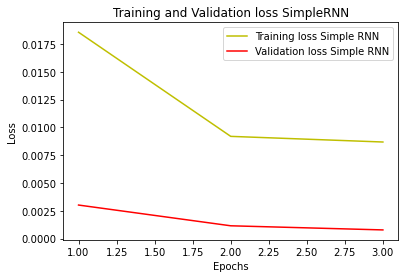

In [13]:
val_acc_per_epoch = history_gru_bog.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_gru_bog = history_gru_bog.history['loss']
val_loss_gru_bog = history_gru_bog.history['val_loss']
epochs = range(1,len(loss_gru_bog)+1)

plt.plot(epochs, loss_gru_bog, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_gru_bog, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_gru_bog = load_model('model_gru.h5')

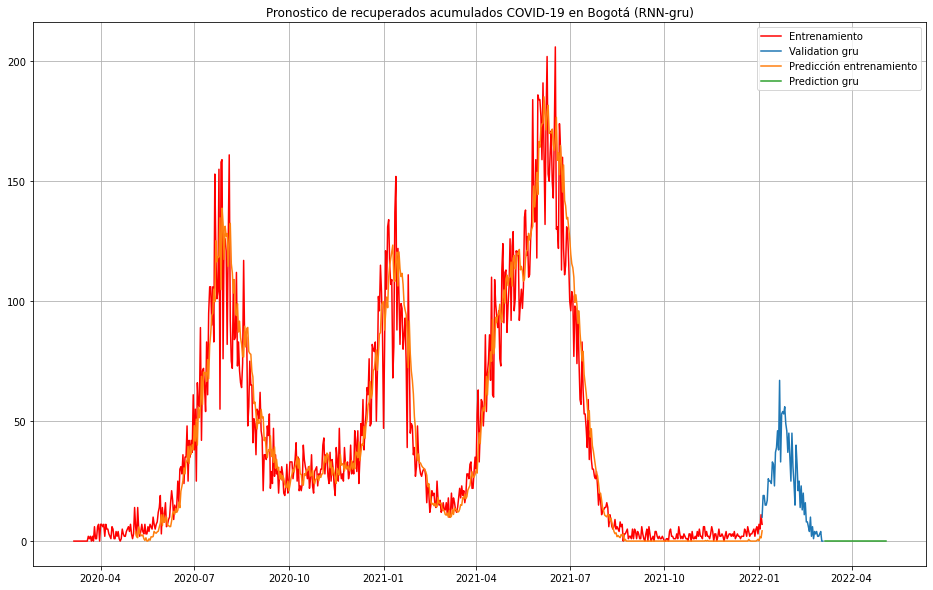

In [12]:
predictions_gru_bog = []

first_batch = bog_scaled_fall[-window_size:]
current_batch_gru_bog = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_gru_bog = model_gru_bog.predict(current_batch_gru_bog)[0]
    

    predictions_gru_bog.append(current_pred_gru_bog)
    
    
    current_batch_rmv_first_gru_bog= current_batch_gru_bog[:,1:,:]
 

    current_batch_gru_bog= np.append(current_batch_rmv_first_gru_bog,[[current_pred_gru_bog]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_bog_fall)
dates_train_data_gru_bog = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_gru_bog = pd.DataFrame({'Date':dates_train_data_gru_bog,'train':train_data_actual_scale[:,0]})
df_train_gru_bog.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_gru_bog = model_gru_bog.predict(train_generator_bog)
train_prediction_data_actual_scale_gru_bog =scaler.inverse_transform(train_prediction_gru_bog)
dates_predict_train_data_gru_bog = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_gru_bog = pd.DataFrame({'Date':dates_predict_train_data_gru_bog,'train':train_prediction_data_actual_scale_gru_bog[:,0]})
df_predict_train_gru_bog.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_gru_bog = scaler.inverse_transform(test_scaled_bog_fall)
dates_test_data_gru_bog = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_gru_bog = pd.DataFrame({'Date':dates_test_data_gru_bog,'Test_gru_bog':test_data_actual_scale_gru_bog[:,0]})
df_test_gru_bog.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_gru_bog = scaler.inverse_transform(predictions_gru_bog)
dates_predictions_gru_bog  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_gru_bog  = pd.DataFrame({'Date':dates_predictions_gru_bog,'Predictions_gru_bog':predictions_actual_scale_gru_bog[:,0]})
df_predictions_gru_bog .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_gru_bog,'r', label='Entrenamiento')
plt.plot(df_test_gru_bog['Test_gru_bog'], label='Validation gru')
plt.plot(df_predict_train_gru_bog['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en Bogotá (RNN-gru)')
plt.plot(df_predictions_gru_bog ['Predictions_gru_bog'], label='Prediction gru')
plt.grid()
plt.legend()


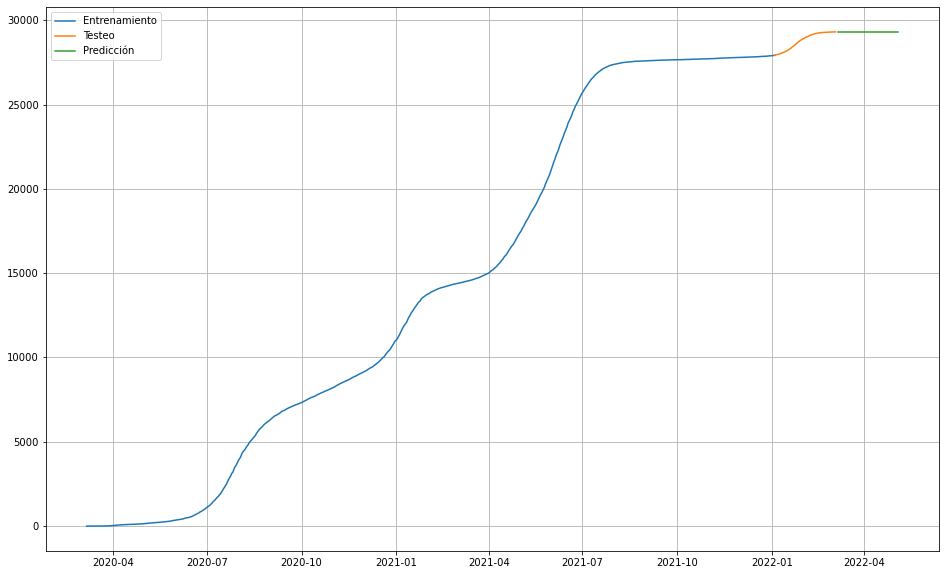

In [13]:
# Creación columna con casos acumulados.
df_predictions_gru_bog['acumulados']= df_predictions_gru_bog['Predictions_gru_bog'].cumsum()
df_predictions_gru_bog['acumulados'] = [i+bogota['FALLECIDOS_ACUMULADOS'].max() for i in df_predictions_gru_bog.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_gru_bog['acumulados']=df_train_gru_bog['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_gru_bog['acumulados']=df_test_gru_bog['Test_gru_bog'].cumsum()
df_test_gru_bog['acumulados'] = [i+df_train_gru_bog['acumulados'].max() for i in df_test_gru_bog.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_gru_bog['acumulados'], label='Entrenamiento' )
plt.plot(df_test_gru_bog['acumulados'], label= 'Testeo')
plt.plot(df_predictions_gru_bog['acumulados'], label='Predicción')
plt.grid()
plt.legend()

In [14]:
df_predictions_gru_bog

,Predictions_gru_bog,acumulados
Date,,
2022-03-06,0.0,29312.0
2022-03-07,0.0,29312.0
2022-03-08,0.0,29312.0
2022-03-09,0.0,29312.0
2022-03-10,0.0,29312.0
2022-03-11,0.0,29312.0
2022-03-12,0.0,29312.0
2022-03-13,0.0,29312.0
2022-03-14,0.0,29312.0
